# LSTM prediction

# With wind direction

## Visualize the data

import libraries

In [105]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [106]:
data = pd.read_csv("/gdrive/My Drive/CS229 final project/ziyad/T1.csv")
# data = pd.read_csv("/gdrive/My Drive/CS229/T1.csv")

In [107]:
# changing datetime to correct format
data["Date/Time"] = pd.to_datetime(data["Date/Time"], format = "%d %m %Y %H:%M", errors = "coerce")
data

,Date/Time,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
0,2018-01-01 00:00:00,380.047791,5.311336,416.328908,259.994904
1,2018-01-01 00:10:00,453.769196,5.672167,519.917511,268.641113
2,2018-01-01 00:20:00,306.376587,5.216037,390.900016,272.564789
3,2018-01-01 00:30:00,419.645905,5.659674,516.127569,271.258087
4,2018-01-01 00:40:00,380.650696,5.577941,491.702972,265.674286
...,...,...,...,...,...
50525,2018-12-31 23:10:00,2963.980957,11.404030,3397.190793,80.502724
50526,2018-12-31 23:20:00,1684.353027,7.332648,1173.055771,84.062599
50527,2018-12-31 23:30:00,2201.106934,8.435358,1788.284755,84.742500
50528,2018-12-31 23:40:00,2515.694092,9.421366,2418.382503,84.297913


In [108]:
data = data.dropna()

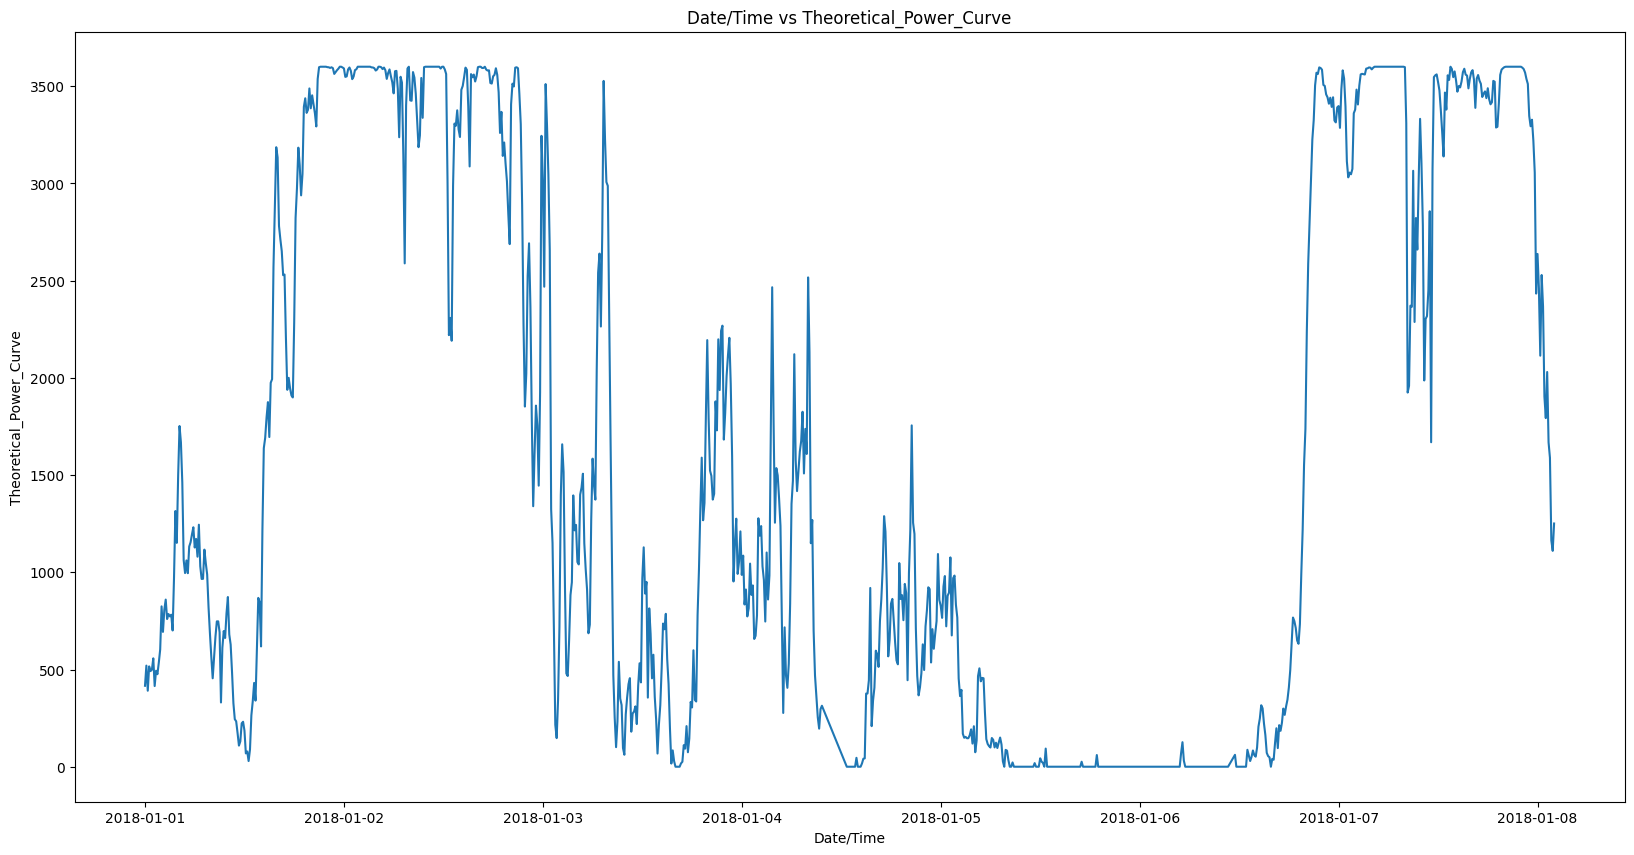

In [109]:

fig, ax = plt.subplots(figsize=(20, 10))

# Add x-axis and y-axis
ax.plot(data['Date/Time'][0:1000],
        data['Theoretical_Power_Curve (KWh)'][0:1000])

# Set title and labels for axes
ax.set(xlabel="Date/Time",
       ylabel="Theoretical_Power_Curve",
       title="Date/Time vs Theoretical_Power_Curve")

plt.show()

## Create the model

import libraries

In [110]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import keras.backend as K

from math import sqrt
import datetime

re-order data

In [111]:
df = data.copy()
cols = ["Date/Time", "LV ActivePower (kW)",	"Wind Speed (m/s)",
        "Wind Direction (°)", "Theoretical_Power_Curve (KWh)"]
df = df[cols]
df = df.set_index('Date/Time')

helper functions

In [112]:
def difference(data): # didn't use
    m = len(data)
    n = len(data[0])
    diffs = np.ndarray((m,n))
    for i in range(1, m):
        value = data[i] - data[i - 1]
        diffs[i,:] = np.array(value)
    return diffs

def scale(data):
    # create scaler
    data = np.reshape(data, (-1, 1))
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(data)
    data_scaled = scaler.transform(data)
    return data_scaled, scaler

def make_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df

In [113]:
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

transform data to supervised learning problem

In [114]:
vals = df.values
diffs = vals # easy way to use same variable
# diffs = difference(vals)
# diffs.shape, diffs[:, 0]

In [115]:
m, n = diffs.shape
scalers = []
data_scaled = np.ndarray(diffs.shape)
for i in range(n):
    data_scaled_col, scaler = scale(diffs[:, i])
    scalers.append(scaler)
    data_scaled[:, i] = np.reshape(data_scaled_col, (m,))

In [116]:
sup = make_supervised(data_scaled, 24)
sup_values = sup.values

split data

In [117]:
num_predict = 1000
train, test = sup_values[:-num_predict], sup_values[-num_predict:]
train.shape

(49530, 100)

In [118]:
x_train, y_train = train[:, 0:-1], train[:, -1]
x_train = x_train.reshape(x_train.shape[0], 1, x_train.shape[1])

hyperparameters

In [119]:
neurons = 200
batch_size = 100
epochs = 15
dropout = .05

make model

In [120]:
model = Sequential()
model.add(LSTM(units=neurons, dropout=dropout, activation='relu', batch_input_shape=(batch_size, x_train.shape[1], x_train.shape[2])))
model.add(Dense(1))  # Output layer for regression tasks
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (100, 200)                240000    
                                                                 
 dense_5 (Dense)             (100, 1)                  201       
                                                                 
Total params: 240201 (938.29 KB)
Trainable params: 240201 (938.29 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


fit model

In [121]:
history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=True)

Epoch 1/15
496/496 [==============================] - 10s 15ms/step - loss: 0.0301 - accuracy: 0.1079
Epoch 2/15
496/496 [==============================] - 5s 10ms/step - loss: 0.0147 - accuracy: 0.1099
Epoch 3/15
496/496 [==============================] - 5s 11ms/step - loss: 0.0125 - accuracy: 0.1100
Epoch 4/15
496/496 [==============================] - 7s 15ms/step - loss: 0.0108 - accuracy: 0.1100
Epoch 5/15
496/496 [==============================] - 6s 11ms/step - loss: 0.0090 - accuracy: 0.1100
Epoch 6/15
496/496 [==============================] - 5s 10ms/step - loss: 0.0073 - accuracy: 0.1100
Epoch 7/15
496/496 [==============================] - 7s 14ms/step - loss: 0.0064 - accuracy: 0.1100
Epoch 8/15
496/496 [==============================] - 7s 14ms/step - loss: 0.0056 - accuracy: 0.1100
Epoch 9/15
496/496 [==============================] - 5s 11ms/step - loss: 0.0049 - accuracy: 0.1100
Epoch 10/15
496/496 [==============================] - 11s 22ms/step - loss: 0.0047 - accu

### predict and plot

In [122]:
x_test, y_test = test[:, 0:-1], test[:, -1]
x_test = x_test.reshape(x_test.shape[0], 1, x_test.shape[1])

In [123]:
predictions = model.predict(x_test, batch_size=1)

1000/1000 [==============================] - 3s 3ms/step


In [124]:
model.evaluate(x_test, y_test)

32/32 [==============================] - 1s 6ms/step - loss: 0.0055 - accuracy: 0.0000e+00


[0.0054782480001449585, 0.0]

plot training metrics

[Text(0.5, 0, 'Epochs'),
 Text(0, 0.5, 'Accuracy'),
 Text(0.5, 1.0, 'Accuracy per Epoch')]

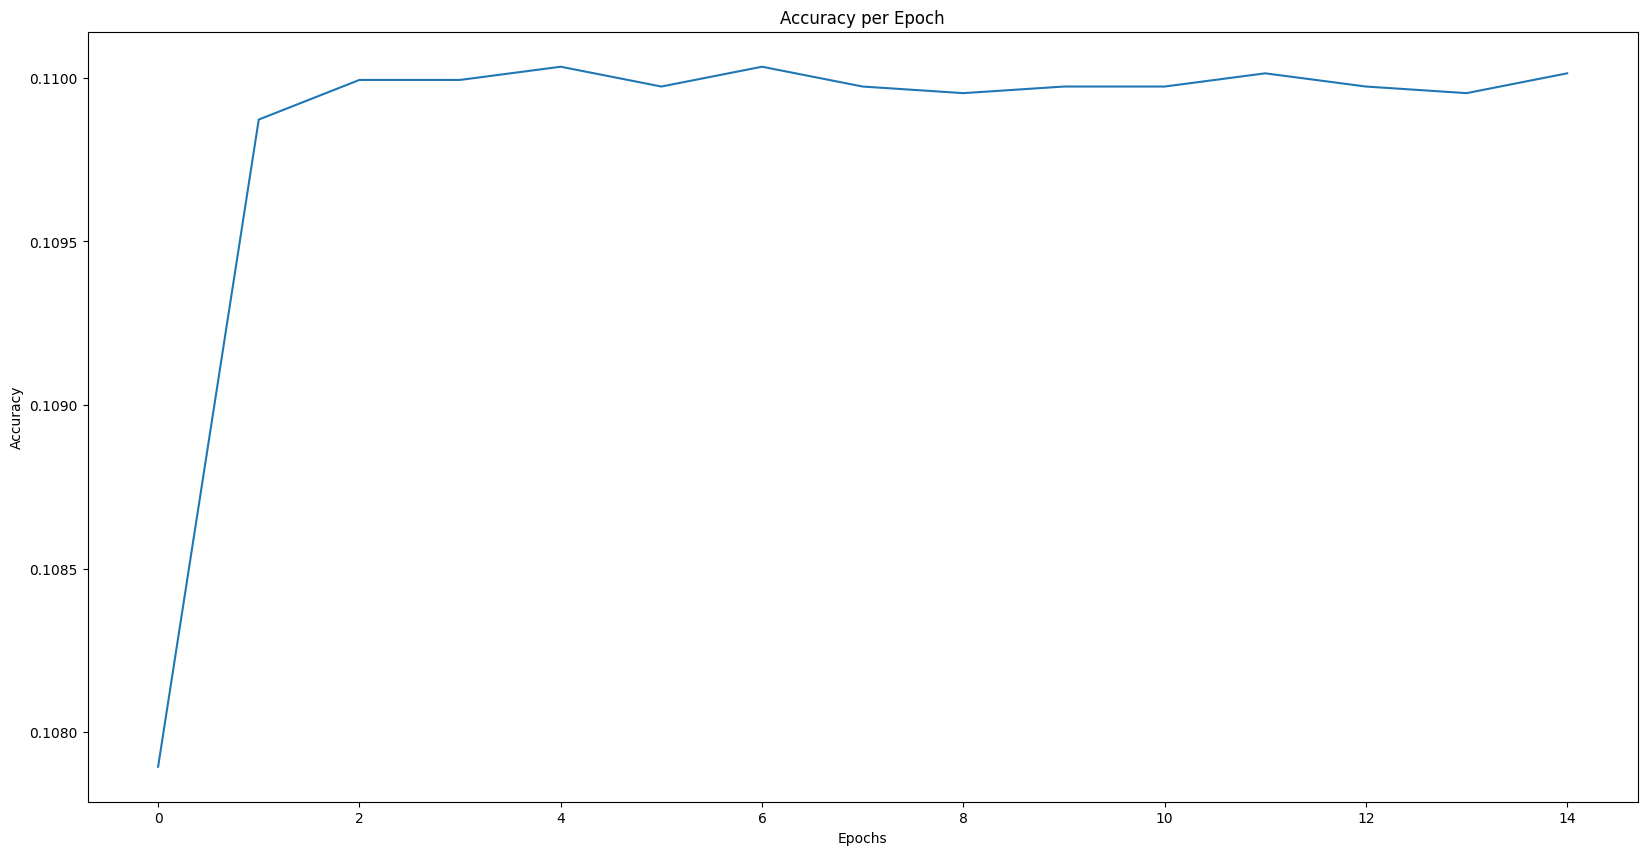

In [125]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(history.history['accuracy'])
ax.set(xlabel="Epochs",
       ylabel="Accuracy",
       title="Accuracy per Epoch")

[Text(0.5, 0, 'Epochs'),
 Text(0, 0.5, 'Loss'),
 Text(0.5, 1.0, 'Loss per Epoch')]

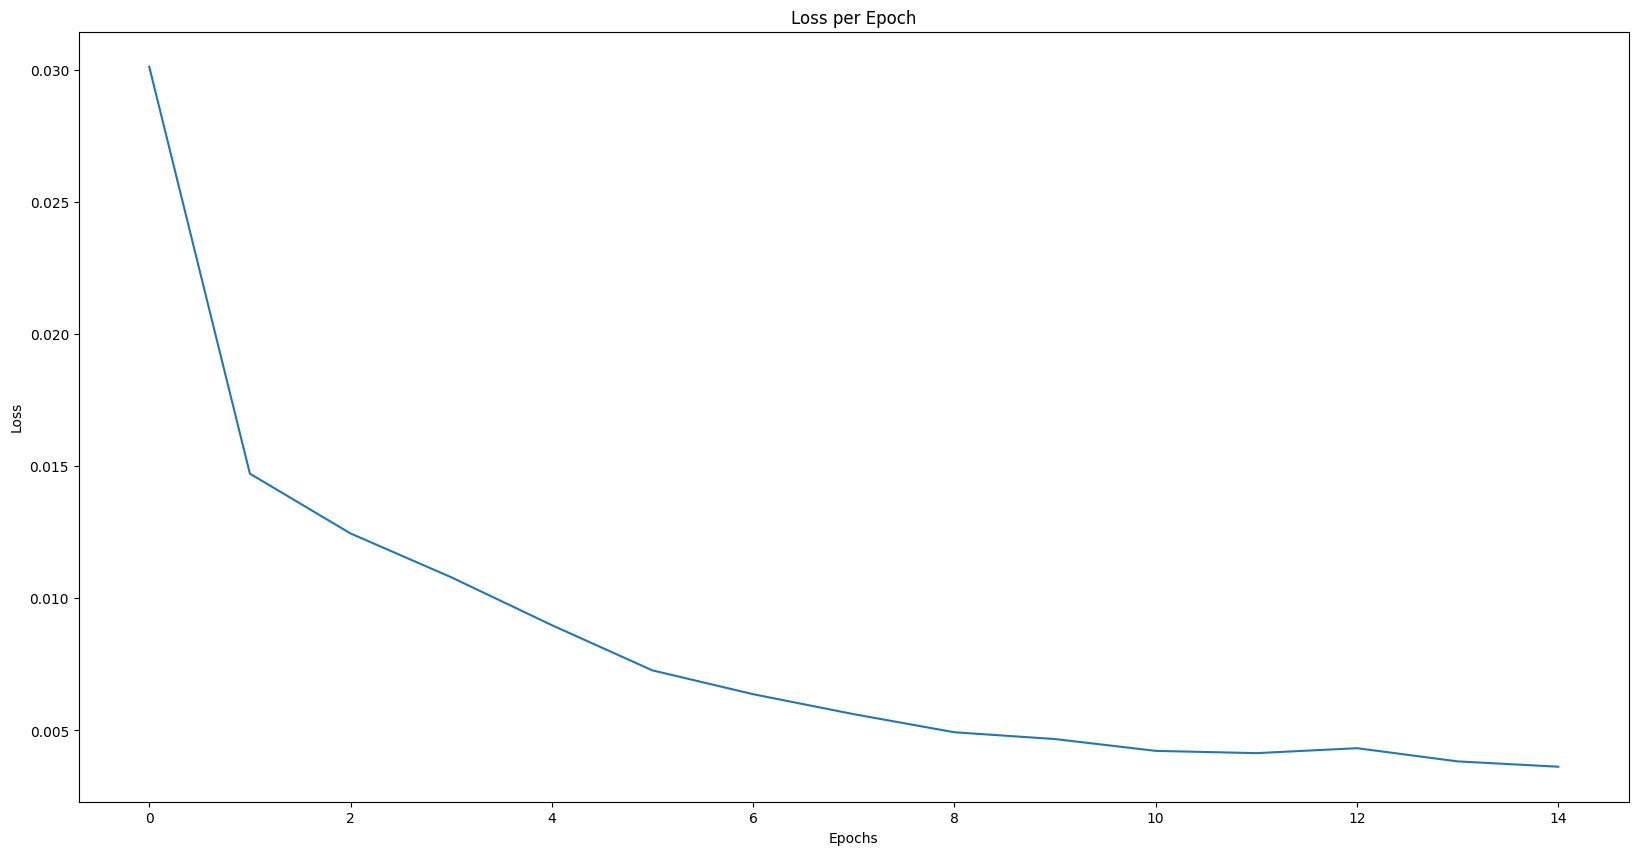

In [126]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(history.history['loss'])
ax.set(xlabel="Epochs",
       ylabel="Loss",
       title="Loss per Epoch")

plot scaled data

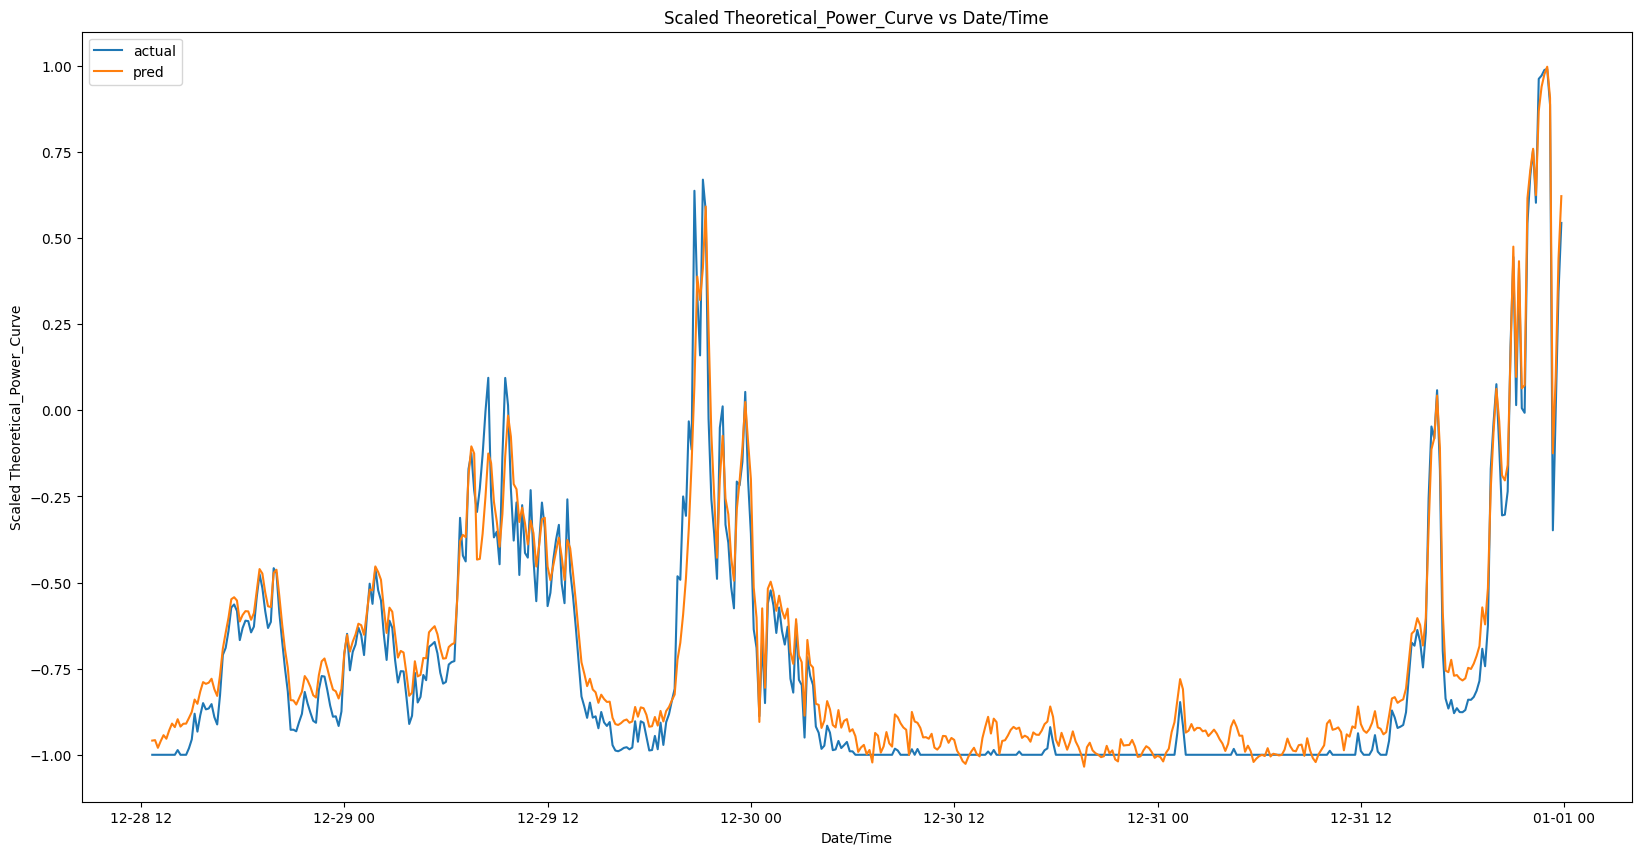

In [127]:
fig, ax = plt.subplots(figsize=(20, 10))

# Add x-axis and y-axis
ax.plot(data['Date/Time'][-500:],
        data_scaled[-500:, -1],
        label="actual")
ax.plot(data['Date/Time'][-500:],
        predictions[-500:], label="pred")

# Set title and labels for axes
ax.set(xlabel="Date/Time",
       ylabel="Scaled Theoretical_Power_Curve",
       title="Scaled Theoretical_Power_Curve vs Date/Time")
ax.legend()

plt.show()

In [128]:
predicted = []
for i in range(len(predictions[-num_predict:])):
    # print(predictions[-500:][i][0])
    predicted.append(predictions[-num_predict:][i][0])
predicted = np.array(predicted)

pred = []
expt = []
expected = data_scaled[-num_predict:, -1]
for i in range(len(expected)):
    if expected[i] == 0:
        continue
    expt.append(expected[i])
    pred.append(predicted[i])

In [129]:
print("Mean Absolute Percent Error: ", np.mean(np.abs(np.array(expt) - np.array(pred) / np.array(expt))))

Mean Absolute Percent Error:  1.818151005792777


plot unscale data

In [130]:
def invert_scale_array(scaler, value):
    inverted = scaler.inverse_transform([value])
    return np.reshape(inverted, (-1, 1))

In [131]:
expected_unscaled = invert_scale_array(scalers[-1], expected)
predicted_unscaled = invert_scale_array(scalers[-1], predicted)

pred = []
expt = []
for i in range(len(expected_unscaled)):
    if expected_unscaled[i] == 0:
        continue
    expt.append(expected_unscaled[i])
    pred.append(predicted_unscaled[i])

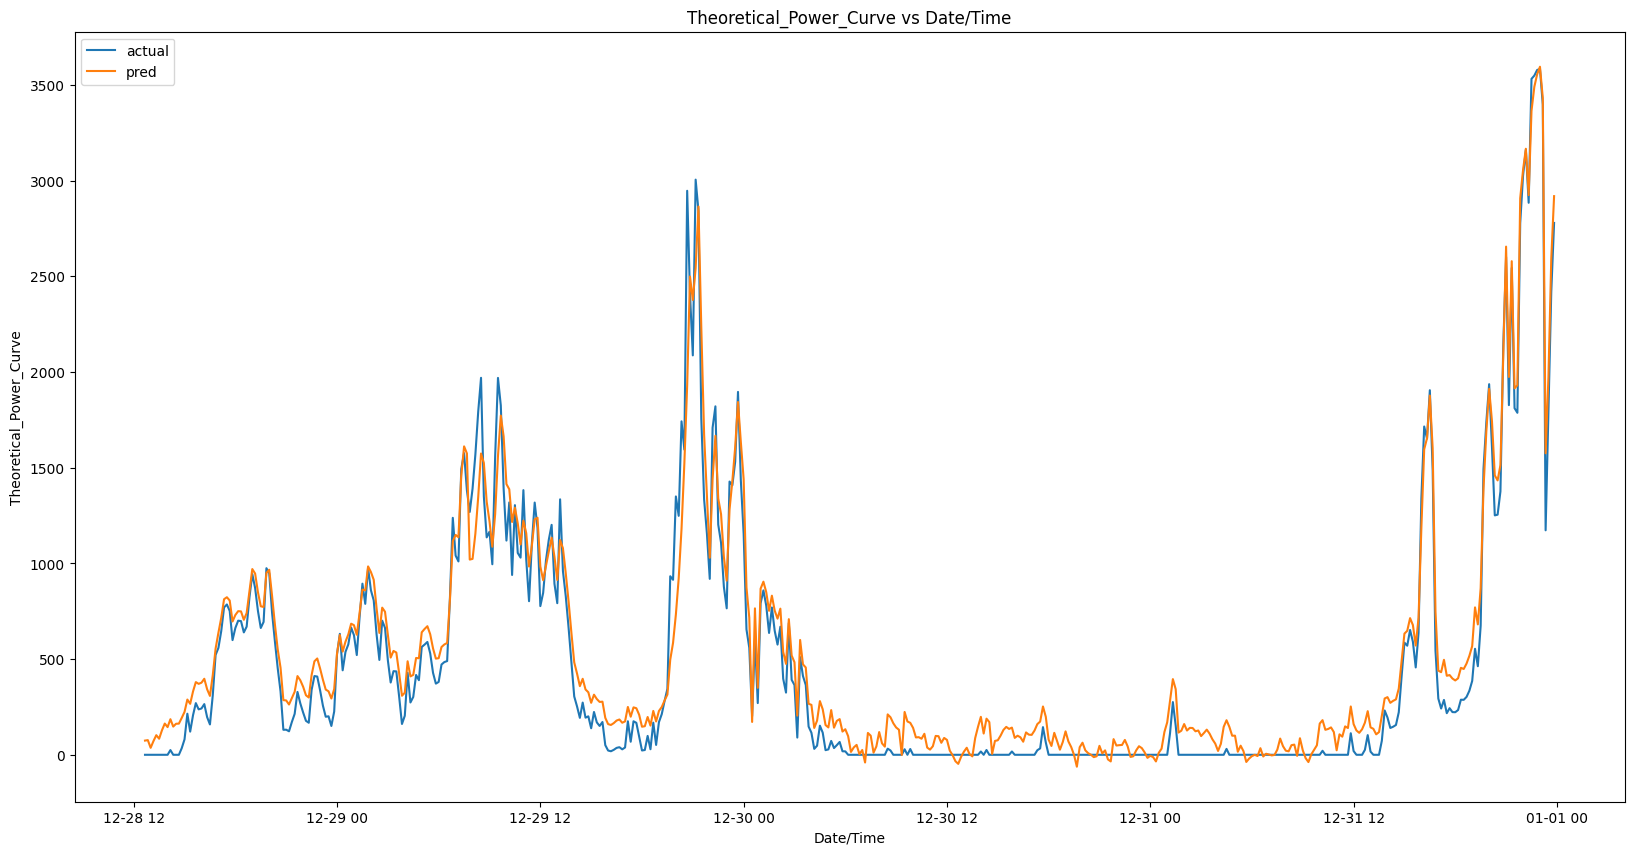

In [132]:
fig, ax = plt.subplots(figsize=(20, 10))

# Add x-axis and y-axis
ax.plot(data['Date/Time'][-500:],
        expected_unscaled[-500:],
        label="actual")
ax.plot(data['Date/Time'][-500:],
        predicted_unscaled[-500:], label="pred")

# Set title and labels for axes
ax.set(xlabel="Date/Time",
       ylabel="Theoretical_Power_Curve",
       title="Theoretical_Power_Curve vs Date/Time")
ax.legend()

plt.show()

In [133]:
print("Mean Absolute Percent Error: ", np.mean(np.abs(np.array(expt) - np.array(pred) / np.array(expt))))

Mean Absolute Percent Error:  994.8167612672963


# Without Wind Direction


### Create the model

In [134]:
df = data.copy()
cols = ["Date/Time", "LV ActivePower (kW)",	"Wind Speed (m/s)",
        "Wind Direction (°)", "Theoretical_Power_Curve (KWh)"]
df = df[cols]
df = df.set_index('Date/Time')

transform data to supervised learning problem

In [135]:
vals = df.values
diffs = vals # easy way to use same variable
# diffs = difference(vals)
# diffs.shape, diffs[:, 0]

In [136]:
m, n = diffs.shape
scalers = []
data_scaled = np.ndarray(diffs.shape)
for i in range(n):
    data_scaled_col, scaler = scale(diffs[:, i])
    scalers.append(scaler)
    data_scaled[:, i] = np.reshape(data_scaled_col, (m,))

In [137]:
sup = make_supervised(data_scaled, 24)
sup_values = sup.values

split data

In [138]:
num_predict = 1000
train, test = sup_values[:-num_predict], sup_values[-num_predict:]
train.shape

(49530, 100)

remove wind direction from data

In [139]:
x_train, y_train = train[:, 0:-2], train[:, -1]
x_train = x_train.reshape(x_train.shape[0], 1, x_train.shape[1])

make model

In [140]:
model = Sequential()
model.add(LSTM(units=neurons, dropout=dropout, activation='relu', batch_input_shape=(batch_size, x_train.shape[1], x_train.shape[2])))
model.add(Dense(1))  # Output layer for regression tasks
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (100, 200)                239200    
                                                                 
 dense_6 (Dense)             (100, 1)                  201       
                                                                 
Total params: 239401 (935.16 KB)
Trainable params: 239401 (935.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


fit model

In [141]:
history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=True)

Epoch 1/15
496/496 [==============================] - 6s 10ms/step - loss: 0.0318 - accuracy: 0.1082
Epoch 2/15
496/496 [==============================] - 6s 12ms/step - loss: 0.0150 - accuracy: 0.1098
Epoch 3/15
496/496 [==============================] - 9s 19ms/step - loss: 0.0125 - accuracy: 0.1100
Epoch 4/15
496/496 [==============================] - 5s 9ms/step - loss: 0.0108 - accuracy: 0.1100
Epoch 5/15
496/496 [==============================] - 5s 9ms/step - loss: 0.0088 - accuracy: 0.1100
Epoch 6/15
496/496 [==============================] - 7s 14ms/step - loss: 0.0074 - accuracy: 0.1100
Epoch 7/15
496/496 [==============================] - 6s 12ms/step - loss: 0.0062 - accuracy: 0.1100
Epoch 8/15
496/496 [==============================] - 5s 9ms/step - loss: 0.0057 - accuracy: 0.1100
Epoch 9/15
496/496 [==============================] - 6s 11ms/step - loss: 0.0049 - accuracy: 0.1100
Epoch 10/15
496/496 [==============================] - 7s 14ms/step - loss: 0.0045 - accuracy:

### predict and plot

remove wind direction from data

In [142]:
x_test, y_test = test[:, 0:-2], test[:, -1]
x_test = x_test.reshape(x_test.shape[0], 1, x_test.shape[1])

In [143]:
predictions = model.predict(x_test, batch_size=1)

1000/1000 [==============================] - 2s 2ms/step


In [144]:
model.evaluate(x_test, y_test)

32/32 [==============================] - 0s 3ms/step - loss: 0.0079 - accuracy: 0.0000e+00


[0.007892193272709846, 0.0]

plot training metrics

[Text(0.5, 0, 'Epochs'),
 Text(0, 0.5, 'Accuracy'),
 Text(0.5, 1.0, 'Accuracy per Epoch')]

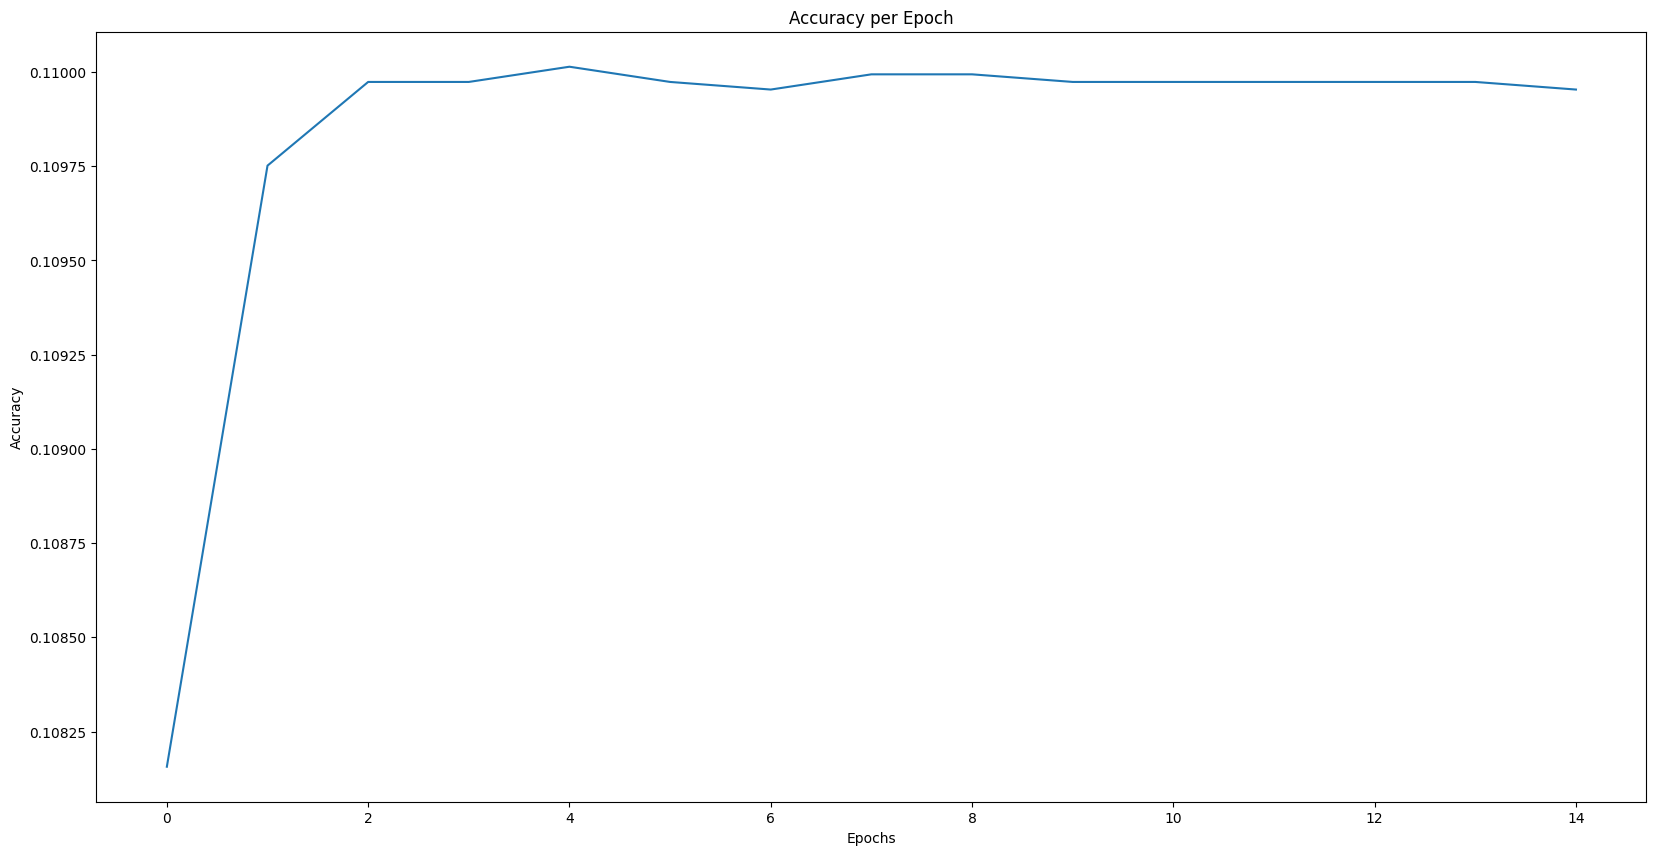

In [145]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(history.history['accuracy'])
ax.set(xlabel="Epochs",
       ylabel="Accuracy",
       title="Accuracy per Epoch")

[Text(0.5, 0, 'Epochs'),
 Text(0, 0.5, 'Loss'),
 Text(0.5, 1.0, 'Loss per Epoch')]

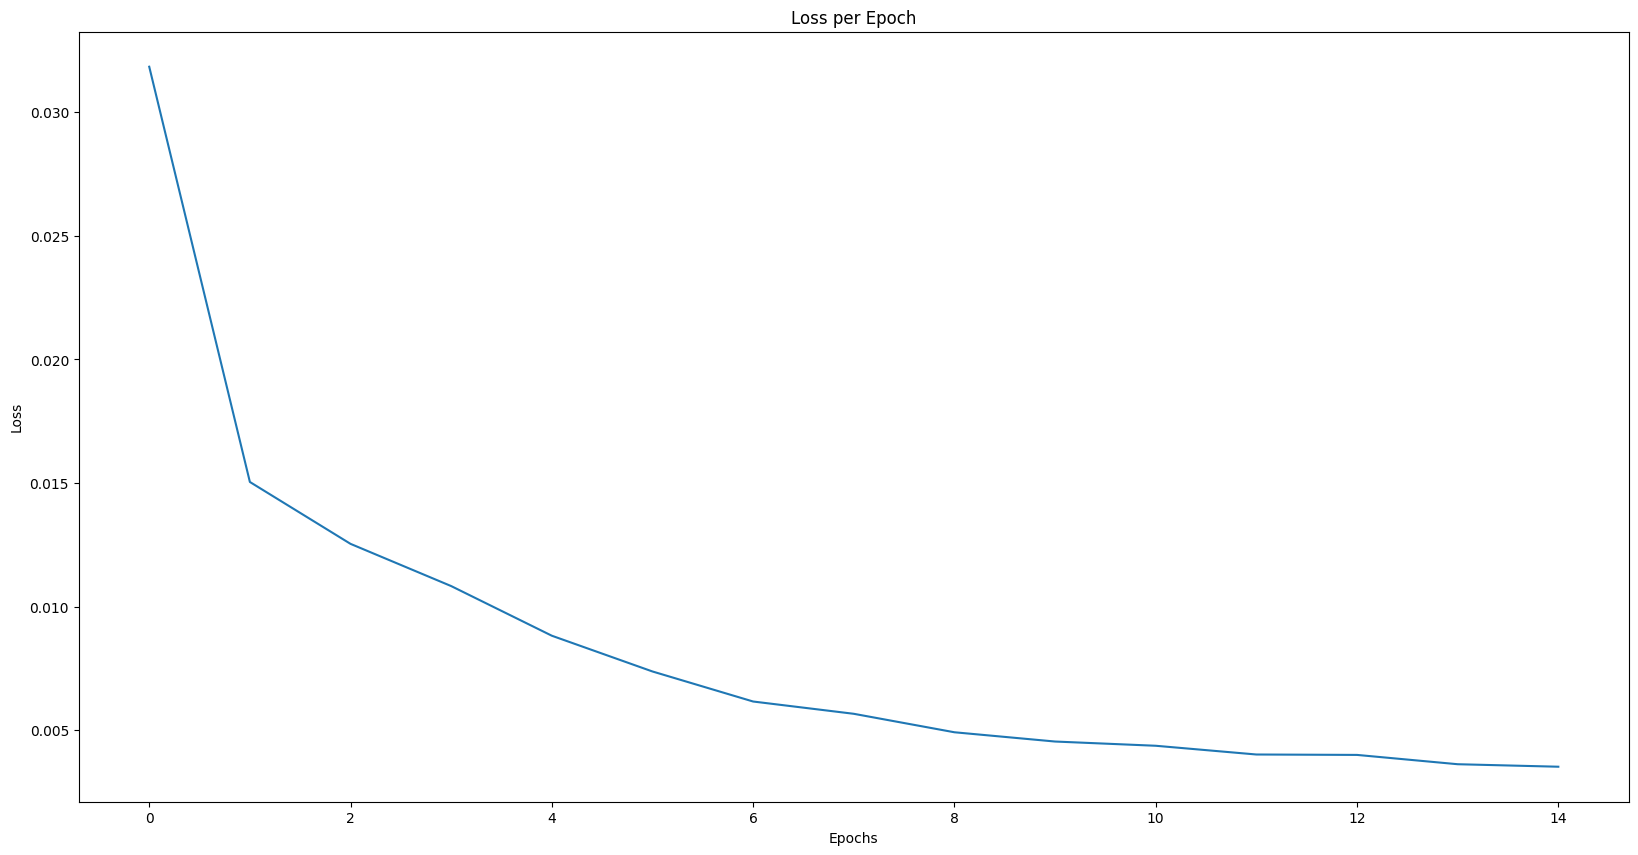

In [146]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(history.history['loss'])
ax.set(xlabel="Epochs",
       ylabel="Loss",
       title="Loss per Epoch")

plot scaled data

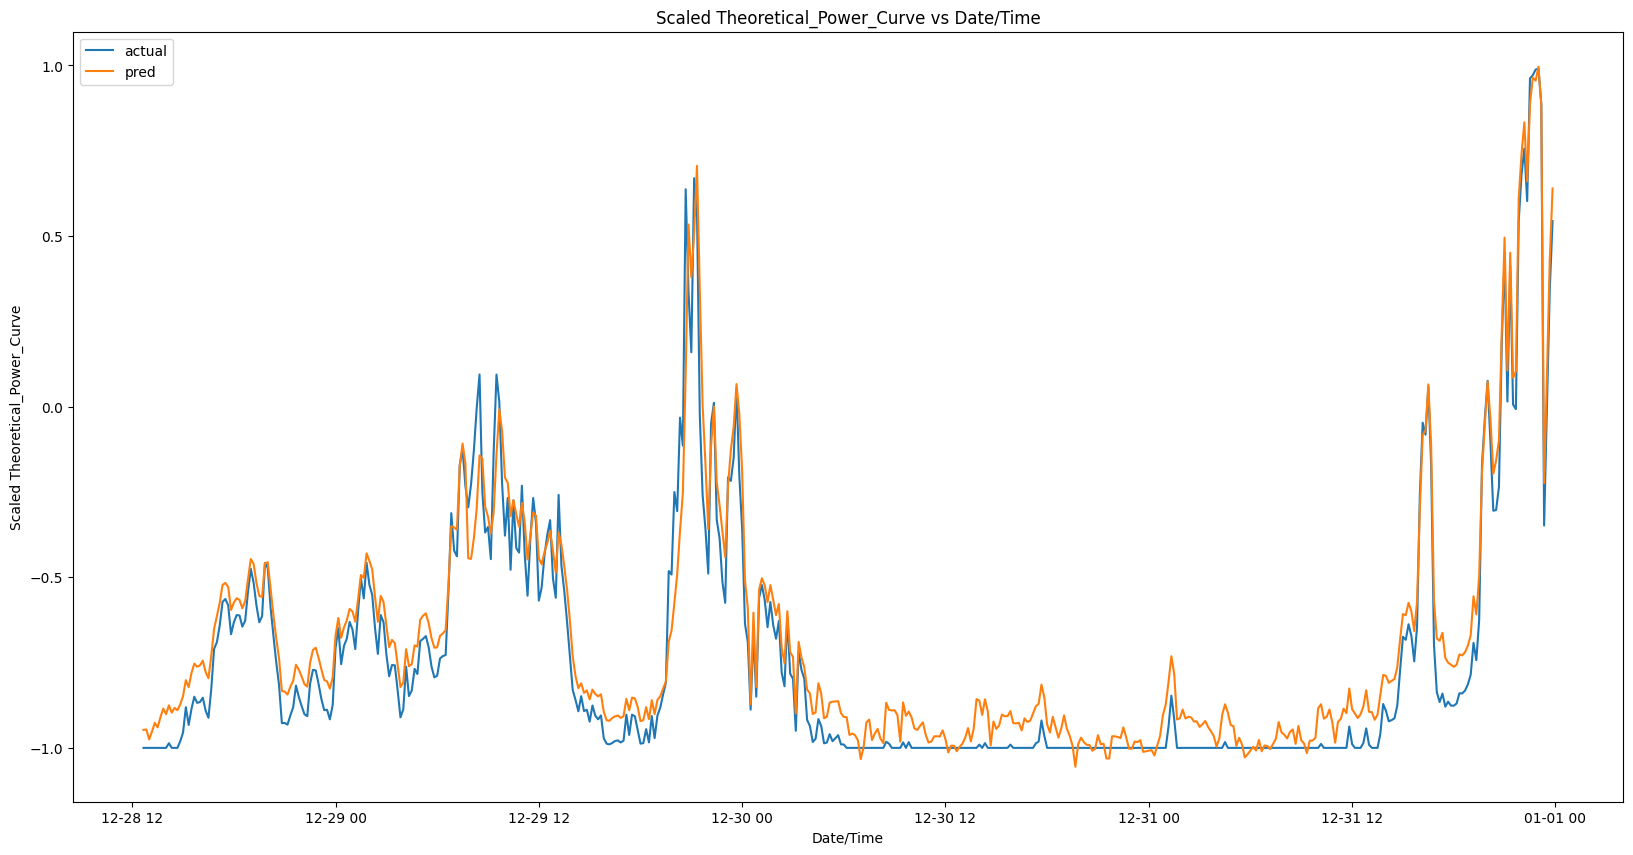

In [147]:
fig, ax = plt.subplots(figsize=(20, 10))

# Add x-axis and y-axis
ax.plot(data['Date/Time'][-500:],
        data_scaled[-500:, -1],
        label="actual")
ax.plot(data['Date/Time'][-500:],
        predictions[-500:], label="pred")

# Set title and labels for axes
ax.set(xlabel="Date/Time",
       ylabel="Scaled Theoretical_Power_Curve",
       title="Scaled Theoretical_Power_Curve vs Date/Time")
ax.legend()

plt.show()

In [148]:
predicted = []
for i in range(len(predictions[-num_predict:])):
    # print(predictions[-500:][i][0])
    predicted.append(predictions[-num_predict:][i][0])
predicted = np.array(predicted)

pred = []
expt = []
expected = data_scaled[-num_predict:, -1]
for i in range(len(expected)):
    if expected[i] == 0:
        continue
    expt.append(expected[i])
    pred.append(predicted[i])

In [149]:
print("Mean Absolute Percent Error: ", np.mean(np.abs(np.array(expt) - np.array(pred) / np.array(expt))))

Mean Absolute Percent Error:  1.8827469071326592


plot unscale data

In [150]:
def invert_scale_array(scaler, value):
    inverted = scaler.inverse_transform([value])
    return np.reshape(inverted, (-1, 1))

In [151]:
expected_unscaled = invert_scale_array(scalers[-1], expected)
predicted_unscaled = invert_scale_array(scalers[-1], predicted)

pred = []
expt = []
for i in range(len(expected_unscaled)):
    if expected_unscaled[i] == 0:
        continue
    expt.append(expected_unscaled[i])
    pred.append(predicted_unscaled[i])

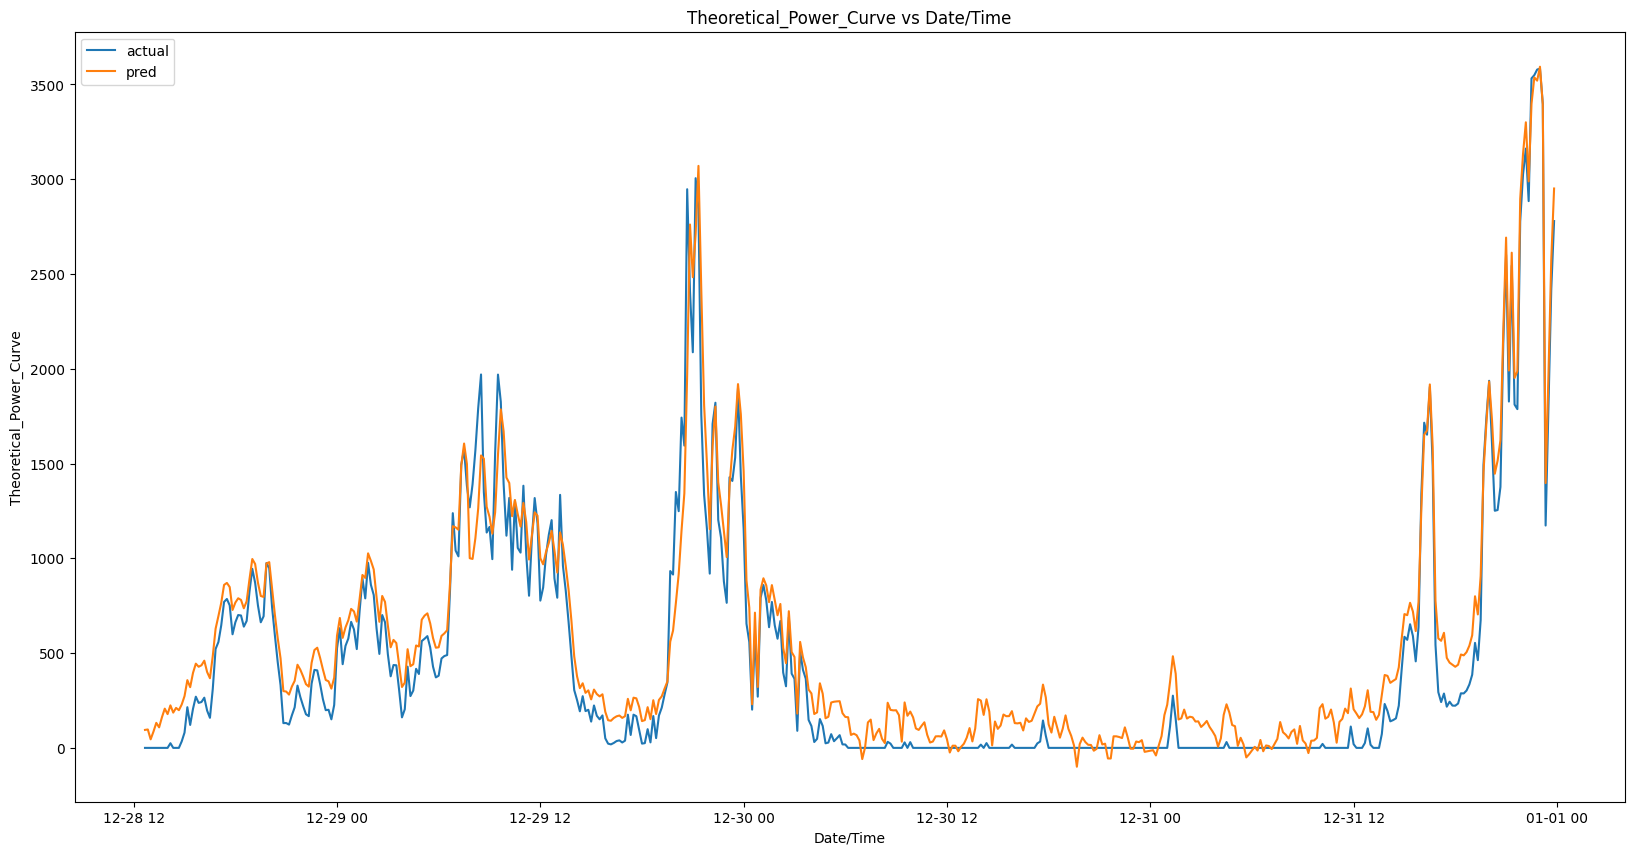

In [152]:
fig, ax = plt.subplots(figsize=(20, 10))

# Add x-axis and y-axis
ax.plot(data['Date/Time'][-500:],
        expected_unscaled[-500:],
        label="actual")
ax.plot(data['Date/Time'][-500:],
        predicted_unscaled[-500:], label="pred")

# Set title and labels for axes
ax.set(xlabel="Date/Time",
       ylabel="Theoretical_Power_Curve",
       title="Theoretical_Power_Curve vs Date/Time")
ax.legend()

plt.show()

In [153]:
print("Mean Absolute Percent Error: ", np.mean(np.abs(np.array(expt) - np.array(pred) / np.array(expt))))

Mean Absolute Percent Error:  994.5161893890553
